In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  import os
  CWD = '/content/drive/MyDrive/DataSources/SkinCare'
  os.chdir(CWD)
except:None
G_path = './Project_Data'

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset as dset
import sys
#import torchvision.transforms.Compose
import numpy as np
from datetime import datetime	
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import pickle as pickle
from statistics import mean
import pandas as pd
pd.options.display.max_colwidth = 250
import sklearn as sk
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
device = None
try:
    c = torch.cuda.is_available()
    if c:
        print('devis: cuda')
        device = 'cuda'
    else:
        try :
            m = torch.backends.mps.is_available()
            if m:
                device = 'mps'
                print('devis: mps')  
        except:    
            device = 'cpu'
            print('devis: cpu')           
except:
    None

devis: cuda


In [3]:
Binary_classification = False
file = 'Input_DataSet_280x210' 
file = 'Input_DataSet_360x270' 
input_data , labels = pickle.load(open(G_path + '/06_Rescaled_DataSet/'+ file,'rb'))
file = 'Balanced_Test_Set_280x210' 
file = 'Balanced_Test_Set_360x270' 
Evaluation_set = pickle.load(open(G_path + '/06_Rescaled_DataSet/' + file,'rb'))

if Binary_classification:
  labels = labels[1]
else:
  labels = labels[0]

# **CNN Networks: Configuration**

In [4]:
net_list = [func for func in dir(CNN_Nets) if callable(getattr(CNN_Nets, func)) and not func.startswith("__")]
X_ = input_data[0][0:5]
for net in net_list:
    print(net)
    model_ = getattr(CNN_Nets,net)
    fc_features = model_().dimention_set(X_)
    print(fc_features)
    model_ = getattr(CNN_Nets,net)
    model_.fc_features = fc_features
    out = model_().forward(X_)
    setattr(CNN_Nets,net,model_)
    # print(out.shape)

Net1
346752
Net10
8512
Net11
2160
Net2
371712
Net3
20160
Net4
20160
Net5
93984
Net6
92928
Net7
768
Net8
768
Net8_a
768
Net8_a_binary
3072
Net8_b
3072
Net8_b_binary
3072
Net9
768


# **Metrics and Performance**

# **Define Training data**

In [5]:
X_train = input_data[0]
Y_train = labels[0]
X_valid = input_data[1]
Y_valid = labels[1]
X_test = input_data[2]
Y_test = labels[2]

# **Model by Grid**

In [6]:
Net = [CNN_Nets.Net8_b]
Drop = [0.2,0.22]
LR = [ 0.5e-3,1e-3,1.5e-3]
batch_size = [24]
Momentum = [0.75,0.85,0.9]
epochs = [100]
patience = [20]
weight_decay = [1e-3,1e-5]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD]

Net = [CNN_Nets.Net8_b]
Drop = [0.1,0.15,0.22,0.2]
LR = [ 1.1e-3,1.3e-3,1.5e-3]
batch_size = [24]
Momentum = [0.88,0.9,0.92]
epochs = [100]
patience = [20]
weight_decay = [0,1e-4]
loss_func  =  [nn.CrossEntropyLoss]
opt_func = [torch.optim.SGD]


grid = {
    'Net' : Net
    ,'Drop' : Drop
    ,'LR' : LR
    ,'batch_size' : batch_size
    ,'Momentum' : Momentum
    ,'epochs' : epochs
    ,'patience': patience
    ,'weight_decay' :weight_decay
    ,'loss_func'  :loss_func
    ,'opt_func' : opt_func
}
params = sk.model_selection.ParameterGrid(grid)

In [7]:
def NNs_grid_searc_cross_valid_trainer(params, X_train ,Y_train, X_valid, Y_valid, X_test, Y_test, kflods, print_epochs, save_results, save_models, cross_valid, nr_repeat, export_name):

    Param_Details = pd.DataFrame(columns=['model_name','hyper_param','test_accuracy','valid_accuracy','train_accuracy','test_specificity','valid_specificity'
                                      ,'train_epoch_loss','train_epoch_acc','valid_epoch_loss','valid_epoch_acc','test_epoch_acc','test_epoch_loss','test_fpr','test_tpr','test_roc_auc','train_index','valid_index'])
    date_hour = datetime.now().strftime("%d_%b%y_%H_%M") 
    Max_train_Acc = 0  
    Max_valid_Acc = 0 
    Max_test_Acc = 0                  
    Min_train_loss = 100
    Min_test_loss = 100

    label_freq = np.bincount(Y_train)
    labels_weights = 1. / label_freq
    weights = labels_weights[Y_train]
    w_sampler = WeightedRandomSampler(weights, len(weights))
    trainDataset = dset(X_train, Y_train)
    validDataset = dset(X_valid, Y_valid)
    testDataset = dset(X_test, Y_test)

    bar = progressbar()

    if cross_valid:
        total_iter = nr_repeat*len(params)*kflods.get_n_splits()
    else: total_iter = nr_repeat*len(params)
    iter = 0
    bar.bar(iter,total_iter, "Interations: ", size=60, show_time=False)
    for i in range(nr_repeat):
        for p in params:
            test_accuracy = []
            test_fscore = []
            test_precision = []
            test_recall = []
            train_index = None
            valid_index = None
            if cross_valid:
                training_data = torch.cat([X_train,X_valid],dim=0)
                training_label = torch.cat([Y_train,Y_valid],dim=0)
                
                for fold, (train_index, valid_index) in enumerate(kflods.split(training_data,training_label)):
                    iter +=1
                    model_name =  export_name + 'Model' + str(iter) + '_' + date_hour
                    X_train_ = training_data[train_index]
                    Y_train_ = training_label[train_index]
                    X_valid_ = training_data[valid_index]
                    Y_valid_ = training_label[valid_index]

                    label_freq = np.bincount(Y_train_)
                    labels_weights = 1. / label_freq
                    weights = labels_weights[Y_train_]
                    w_sampler = WeightedRandomSampler(weights, len(weights))
                    trainDataset = dset(X_train_, Y_train_)
                    validDataset = dset(X_valid_, Y_valid_)
                    
                    
                    torch.cuda.empty_cache()
                    Model_ = Model_Training_with_loader(**p,w_sampler = w_sampler , trainDataset = trainDataset, validDataset = validDataset, testDataset=testDataset, print_epochs =print_epochs,hyper_params=p, device=device)
                    np.random.seed(0)
                    random.seed(0)
                    torch.manual_seed(0)
                    torch.cuda.manual_seed(0)
                    torch.backends.cudnn.deterministic = True
                    Model_.train()

                    train_accuracy = max(Model_.Epochs_Train_Acc)
                    train_epoch_loss = Model_.Epochs_Train_loss
                    train_epoch_acc = Model_.Epochs_Train_Acc
                    valid_epoch_loss = Model_.Epochs_Val_loss
                    valid_epoch_acc = Model_.Epochs_Val_Acc
                    test_epoch_loss = Model_.Epochs_test_loss
                    test_epoch_acc = Model_.Epochs_test_Acc
                    train_loss = mean(Model_.Epochs_Train_loss[-5:])
                    test_loss = mean(Model_.Epochs_test_loss[-5:])

                    model_ = Model_.model.eval().to('cpu')
                    # test Performance
                    X = X_test
                    Y = Y_test
                    Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
                    Y_pred_prob = model_.forward_noDrop(X)
                    Y_pred = model_.forward_noDrop(X).argmax(dim=1)
                    per_ = recall_specificity(Y,Y_pred).loc['Weighted Avg.']
                    test_accuracy , test_specificity = per_['Recall_Sensitivity'] , per_['Specificity']
                    test_fpr, test_tpr, test_roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob.detach().numpy())

                    # Valid performance
                    X = X_valid
                    Y = Y_valid
                    Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
                    Y_pred_prob = model_.forward_noDrop(X)
                    Y_pred = model_.forward_noDrop(X).argmax(dim=1)
                    per_ = recall_specificity(Y,Y_pred).loc['Weighted Avg.']
                    valid_accuracy , valid_specificity = per_['Recall_Sensitivity'] , per_['Specificity']

                    new_row = pd.Series({'model_name':model_name,'hyper_param':p,'test_accuracy':test_accuracy,'valid_accuracy':valid_accuracy,'train_accuracy':train_accuracy,'test_specificity':test_specificity,'valid_specificity':valid_specificity
                                      ,'train_epoch_loss':train_epoch_loss,'train_epoch_acc':train_epoch_acc,'valid_epoch_loss':valid_epoch_loss,'valid_epoch_acc':valid_epoch_acc,'test_epoch_acc':test_epoch_acc,'test_epoch_loss':test_epoch_loss
                                      ,'test_fpr':test_fpr,'test_tpr':test_tpr,'test_roc_auc':test_roc_auc,'train_index':train_index,'valid_index':valid_index}, name='')
                    Param_Details = Param_Details.append(new_row)

                    if test_accuracy > Max_test_Acc: pickle.dump(model_ , open(G_path +'/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/Best_Models/' +  export_name +'_' + date_hour, 'wb'))

                    if save_results:
                    # Hyper_Details.to_csv(G_path +'/Saved/Grid_Search_Results/' + export_name + date_hour+ '.csv')
                        pickle.dump(m_details, open(G_path +'/08_Saved_Models_Outpus/Grid_Search_Results/' + model_name, 'wb'))
                        pickle.dump(Param_Details, open(G_path +'/08_Saved_Models_Outpus/Grid_Search_Results/Overall/' + export_name + '_' + date_hour , 'wb'))

                    if save_models:
                        pickle.dump(model_, open(G_path +'/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' +  model_name, 'wb'))
                    
                    if train_accuracy > Max_train_Acc: Max_train_Acc = train_accuracy
                    if valid_accuracy > Max_valid_Acc: Max_valid_Acc = valid_accuracy
                    if test_accuracy > Max_test_Acc: Max_test_Acc = test_accuracy
                    if train_loss < Min_train_loss: Min_train_loss = train_loss
                    if test_loss < Min_test_loss: Min_test_loss = test_loss

                    bar.set_pre_description(f'=> Max_Train_Ac: {Max_train_Acc:.1%}, Max_Valid_Ac: {Max_valid_Acc:.1%}, Max_Test_Ac: {Max_test_Acc:.1%}, Min_train_loss: {Min_train_loss:.1f}, Min_test_loss: {Min_test_loss:.1f} ')
                    bar.set_first_description(f'=> last model: Train_Ac: {train_accuracy:.1%}, Valid_Ac: {valid_accuracy:.1%}, Test_Ac: {test_accuracy:.1%}, train_loss: {train_loss:.1f}, test_loss: {test_loss:.1f} ')
                    bar.bar(iter,total_iter)

            else:
                    
                    iter +=1
                    
                    model_name =  export_name + 'Model' + str(iter) + '_' + date_hour
                    torch.cuda.empty_cache()
                    Model_ = Model_Training_with_loader(**p,w_sampler = w_sampler , trainDataset = trainDataset, validDataset = validDataset, testDataset=testDataset, print_epochs =print_epochs,hyper_params=p, device=device)
                    np.random.seed(0)
                    random.seed(0)
                    torch.manual_seed(0)
                    torch.cuda.manual_seed(0)
                    torch.backends.cudnn.deterministic = True
                    Model_.train()
                    train_accuracy = max(Model_.Epochs_Train_Acc)
                    train_epoch_loss = Model_.Epochs_Train_loss
                    train_epoch_acc = Model_.Epochs_Train_Acc
                    valid_epoch_loss = Model_.Epochs_Val_loss
                    valid_epoch_acc = Model_.Epochs_Val_Acc
                    test_epoch_loss = Model_.Epochs_test_loss
                    test_epoch_acc = Model_.Epochs_test_Acc
                    train_loss = mean(Model_.Epochs_Train_loss[-5:])
                    test_loss = mean(Model_.Epochs_test_loss[-5:])

                    model_ = Model_.model.eval().to('cpu')
                    # test Performance
                    X = X_test
                    Y = Y_test
                    Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
                    Y_pred_prob = model_.forward_noDrop(X)
                    Y_pred = model_.forward_noDrop(X).argmax(dim=1)
                    per_ = recall_specificity(Y,Y_pred).loc['Weighted Avg.']
                    test_accuracy , test_specificity = per_['Recall_Sensitivity'] , per_['Specificity']
                    test_fpr, test_tpr, test_roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob.detach().numpy())
                    # Valid performance
                    X = X_valid
                    Y = Y_valid
                    Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
                    Y_pred_prob = model_.forward_noDrop(X)
                    Y_pred = model_.forward_noDrop(X).argmax(dim=1)
                    per_ = recall_specificity(Y,Y_pred).loc['Weighted Avg.']
                    valid_accuracy , valid_specificity = per_['Recall_Sensitivity'] , per_['Specificity']

                    new_row = pd.Series({'model_name':model_name,'hyper_param':p,'test_accuracy':test_accuracy,'valid_accuracy':valid_accuracy,'train_accuracy':train_accuracy,'test_specificity':test_specificity,'valid_specificity':valid_specificity
                                      ,'train_epoch_loss':train_epoch_loss,'train_epoch_acc':train_epoch_acc,'valid_epoch_loss':valid_epoch_loss,'valid_epoch_acc':valid_epoch_acc
                                      ,'test_epoch_acc':test_epoch_acc,'test_epoch_loss':test_epoch_loss,'test_fpr':test_fpr,'test_tpr':test_tpr,'test_roc_auc':test_roc_auc,'train_index':train_index,'valid_index':valid_index}, name='')
                    Param_Details = Param_Details.append(new_row)
                    m_details = pd.DataFrame()
                    m_details = m_details.append(new_row)
                    
                    if test_accuracy > Max_test_Acc: pickle.dump(model_ , open(G_path +'/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/Best_Models/' +  export_name +'_' + date_hour, 'wb'))

                    if save_results:
                    # Hyper_Details.to_csv(G_path +'/Saved/Grid_Search_Results/' + export_name + date_hour+ '.csv')
                        pickle.dump(m_details, open(G_path +'/08_Saved_Models_Outpus/Grid_Search_Results/' + model_name, 'wb'))
                        pickle.dump(Param_Details, open(G_path +'/08_Saved_Models_Outpus/Grid_Search_Results/Overall/' + export_name + '_' + date_hour , 'wb'))

                    if save_models:
                        pickle.dump(model_, open(G_path +'/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/' +  model_name, 'wb'))

                    if train_accuracy > Max_train_Acc: Max_train_Acc = train_accuracy
                    if valid_accuracy > Max_valid_Acc: Max_valid_Acc = valid_accuracy
                    if test_accuracy > Max_test_Acc: Max_test_Acc = test_accuracy
                    if train_loss < Min_train_loss: Min_train_loss = train_loss
                    if test_loss < Min_test_loss: Min_test_loss = test_loss

                    bar.set_pre_description(f'=> Max_Train_Ac: {Max_train_Acc:.1%}, Max_Valid_Ac: {Max_valid_Acc:.1%}, Max_Test_Ac: {Max_test_Acc:.1%}, Min_train_loss: {Min_train_loss:.1f}, Min_test_loss: {Min_test_loss:.1f} ')
                    bar.set_first_description(f'=> last model: Train_Ac: {train_accuracy:.1%}, Valid_Ac: {valid_accuracy:.1%}, Test_Ac: {test_accuracy:.1%}, train_loss: {train_loss:.1f}, test_loss: {test_loss:.1f} ')
                    bar.bar(iter,total_iter)
                    
    Best_Grid_Model = pickle.load(open(G_path +'/08_Saved_Models_Outpus/Models/CNN_Grid_Search_Models/Best_Models/' +  export_name +'_' + date_hour, 'rb'))
    Param_Details.sort_values('test_accuracy', ascending=False,inplace=True)
    best_param = Param_Details['hyper_param'][0]
    return Param_Details, Best_Grid_Model
    # best_one = np.argmax(Param_Details.test_recall_weighed)
    # best_param = Param_Details.iloc[best_one]['hyper_param']
    # best_train_index = Param_Details.iloc[best_one]['train_index'] 
    # best_valid_index = Param_Details.iloc[best_one]['valid_index']  
    # if cross_valid:
    #         x_train_ = training_data[best_train_index]
    #         y_train_ = training_label[best_train_index]
    #         x_valid_ = training_data[best_valid_index]
    #         y_valid_ = training_label[best_valid_index]

    # Best_Model = Model_.set_params(**best_param)
    # Best_Model.fit(x_train_, y_train_)
    # Y_pred = Best_Model.predict(X_test)
    # Param_Details['hyper_param'] = Param_Details['hyper_param'].apply(lambda x: json.dumps(x))
    # print('------- Precision recal %--------')
    # print(sk.metrics.classification_report(Y_test,Y_pred))
    # print('Best param: ' , best_param)
    # return Best_Model, Param_Details

In [ ]:
print_epochs = False
save_results = True
save_models = True
cross_valid = False
nr_repeat = 1

shape_ = str(X_train[0].shape[1])+'x'+str(X_train[0].shape[2])
export_name = 'CNN_' + shape_ +'_MultiClass' # {'280_210_','AutoEncoder_'}
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
Param_Details, Best_Grid_Model = NNs_grid_searc_cross_valid_trainer(params, X_train ,Y_train, X_valid, Y_valid, X_test, Y_test, kflods, print_epochs, save_results, save_models, cross_valid, nr_repeat, export_name)

   [............................................................] 0/72     

Earlt Stoppo happen at Epoche 41 after no improvment of 21 epochs 
 => Max_Train_Ac: 88.0%, Max_Valid_Ac: 64.9%, Max_Test_Ac: 61.7%, Min_train_loss: 0.3, Min_test_loss: 1.0  [..............................] 1/72 [Time => Iter.: 415.8s, Tot.: 415.8s, Remain.: 29520.4s] => last model: Train_Ac: 88.0%, Valid_Ac: 64.9%, Test_Ac: 61.7%, train_loss: 0.3, test_loss: 1.0   

Earlt Stoppo happen at Epoche 41 after no improvment of 21 epochs 
 => Max_Train_Ac: 88.2%, Max_Valid_Ac: 64.9%, Max_Test_Ac: 62.2%, Min_train_loss: 0.3, Min_test_loss: 1.0  [..............................] 2/72 [Time => Iter.: 447.8s, Tot.: 863.6s, Remain.: 30224.5s] => last model: Train_Ac: 88.2%, Valid_Ac: 63.6%, Test_Ac: 62.2%, train_loss: 0.3, test_loss: 1.0   

Earlt Stoppo happen at Epoche 41 after no improvment of 21 epochs 
 => Max_Train_Ac: 89.6%, Max_Valid_Ac: 64.9%, Max_Test_Ac: 62.2%, Min_train_loss: 0.3, Min_test_loss: 1.0  [█.......

In [22]:
date_hour

NameError: ignored

NameError: ignored

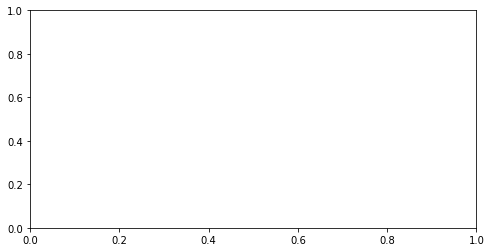

In [23]:
plt.subplots(figsize=(8,4))
sns.boxplot(data=model_recalls)
plt.title('Test performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

plt.subplots(figsize=(8,4))
sns.boxplot(data=model_specificity)
plt.title('Valid performance of 100 Cross-Validation',fontsize = 18)
plt.xlabel("Classifiers", fontsize = 14)
plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()
